In [1]:
import librosa
import librosa.display
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
from collections import deque
import IPython.display 
from IPython.display import clear_output
from functools import partial

In [3]:
CHANNELS = 1

class StreamProcessor:
    def __init__(self, sample_rate, chunk_size, hop_length, n_fft, verbose=False, query_norm=None):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.verbose = verbose
        self.query_norm = query_norm
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.chroma_buffer = queue.Queue()
        self.last_chunk = None
        self.is_mic_open = False
        self.index = 0
    
    def _process_chroma(self, y, time_info=None):
        y = np.concatenate((self.last_chunk, y)) if self.last_chunk is not None else y
        query_chroma_stft = librosa.feature.chroma_stft(  # TODO: center = False 옵션 줘서 해보기
            y=y,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            n_fft=self.n_fft,
            norm=self.query_norm
        )
        # 첫번째 chunk 는 맨 앞의 padding된 stft frame을 버리지 않음
        query_chroma_stft = query_chroma_stft[:, 1:-1] if self.last_chunk is not None else query_chroma_stft[:, :-1]
        query_chroma_stft = np.log(query_chroma_stft * 5 + 1) / 4
        current_chunk = {
            "timestamp": time_info if time_info else time.time(),
            "chroma_stft": query_chroma_stft,
        }
        self.chroma_buffer.put(current_chunk)
        self.last_chunk = y[y.shape[0] - self.hop_length:]
        self.index += 1

    def _process_frame(self, data, frame_count, time_info, status_flag):
        if self.verbose:
            print(f'\nprocess_frame index: {self.index}, frame_count: {frame_count}')
            print(f"{self.index}st time_info: {time_info}")

        self.buffer.put(data)

        query_audio = np.frombuffer(data, dtype=np.float32)  # initial y
        self._process_chroma(query_audio, time_info["input_buffer_adc_time"])

        return (data, pyaudio.paContinue)
    
    def mock_stream(self, mock_file=None):
        filename = mock_file or "../resources/audio/target/presto_musescore/Haydn_Hob._XVI34_1._Presto.wav"
        stream = librosa.stream(
            filename, 
            block_length=int(self.chunk_size/self.hop_length), 
            frame_length=self.chunk_size,
            hop_length=self.hop_length
        )
        for y_block in stream:
            print(f"y_block.shape: {y_block.shape}")
            self._process_chroma(y_block)


    def run(self, mock=False, mock_file=None):
        if mock:
            print(f"* [Mocking] Loading existing audio file({mock_file})....")
            self.mock_stream(mock_file)
            print("* [Mocking] Done.")
        else:
            self.audio_interface = pyaudio.PyAudio()
            self.audio_stream = self.audio_interface.open(
                format=self.format,
                channels=self.channels,
                rate=self.sample_rate,
                input=True,
                frames_per_buffer=self.chunk_size,
                stream_callback=self._process_frame,
            )
            self.is_mic_open = True
            self.audio_stream.start_stream()
            self.start_time = self.audio_stream.get_time()
            print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")
    
    def is_open(self):
        return self.is_mic_open

In [4]:
MAX_LEN = int(1e4)

from enum import IntEnum
import scipy


class Direction(IntEnum):
    REF = 1
    QUERY = 2
    BOTH = REF | QUERY

class OnlineTimeWarping:
    def __init__(
        self,
        sp: StreamProcessor,
        ref_audio_path,
        window_size,
        hop_length,
        max_run_count=30,
        verbose=False,
        ref_norm=None,
    ):
        self.sp = sp
        self.ref_audio_file = ref_audio_path
        self.w = window_size # * self.frame_per_seg
        self.max_run_count = max_run_count
        self.hop_length = hop_length
        self.frame_per_seg = int(sp.chunk_size / hop_length)
        self.verbose = verbose
        self.ref_norm = ref_norm
        self.ref_pointer = 0
        self.query_pointer = 0
        self.run_count = 0
        self.previous_direction = None
        self.current_query_stft = None  # (12, n)
        self.query_stft = np.zeros((12, MAX_LEN))  # (12, N) stft of total query
        self.dist_matrix = None
        self.acc_dist_matrix = None
        self.candidate = None
        self.candi_history = []
        self.iteration = 0

        self.initialize_ref_audio(ref_audio_path)

    def offset(self):
        offset_x = max(self.ref_pointer - self.w, 0)
        offset_y = max(self.query_pointer - self.w, 0)
        return np.array([offset_x, offset_y])

    def initialize_ref_audio(self, audio_path):
        audio_y, sr = librosa.load(audio_path)
        self.ref_audio = audio_y
        ref_stft = librosa.feature.chroma_stft(
            y=audio_y, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT, norm=self.ref_norm
        )
        ref_len = ref_stft.shape[1]
        truncated_len = (
            (ref_len - 1) // self.frame_per_seg
        ) * self.frame_per_seg  # initialize_ref_audio 에서 ref_stft 길이가 frame_per_seg (4) 로 나눠지게 마지막을 버림
        self.ref_stft = ref_stft[:, :truncated_len]
        self.ref_stft = np.log(self.ref_stft * 10 + 1) / 8
        self.ref_total_length = self.ref_stft.shape[1]

        self.global_cost_matrix = np.zeros(
            (self.ref_total_length * 2, self.ref_total_length * 2)
        )

    def init_dist_matrix(self):
        print("init")
        ref_stft_seg = self.ref_stft[:, : self.ref_pointer]  # [F, M]
        query_stft_seg = self.query_stft[:, : self.query_pointer]  # [F, N]
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)
        self.dist_matrix[self.w - dist.shape[0] :, self.w - dist.shape[1] :] = dist

    def init_matrix(self):
        x = self.ref_pointer
        y = self.query_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))
        x_seg = self.ref_stft[:, x - wx : x].T  # [wx, 12]
        y_seg = self.query_stft[:, y - d : y].T  # [d, 12]
        dist = scipy.spatial.distance.cdist(x_seg, y_seg)  # [wx, d]

        for i in range(wx):
            for j in range(d):
                local_dist = dist[i, j]
                update_x0 = 0
                update_y0 = wy - d
                if i == 0 and j == 0:
                    new_acc[i, j] = local_dist
                elif i == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                    new_len_acc[i, update_y0 + j] = 1 + new_len_acc[i, update_y0 - 1]
                elif j == 0 :
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i-1, update_y0]
                    new_len_acc[i, update_y0 + j] = local_dist + new_len_acc[i-1, update_y0]
                else:
                    compares = [
                        new_acc[i - 1, update_y0 + j],
                        new_acc[i, update_y0 + j - 1],
                        new_acc[i - 1, update_y0 + j - 1] * 0.98,
                    ]
                    len_compares = [
                        new_len_acc[i - 1, update_y0 + j],
                        new_len_acc[i, update_y0 + j - 1],
                        new_len_acc[i - 1, update_y0 + j - 1],
                    ]
                    local_direction = np.argmin(compares)
                    new_acc[i, update_y0 + j] = local_dist + compares[local_direction]
                    new_len_acc[i, update_y0 + j] = 1 + len_compares[local_direction]
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc
        self.select_candidate()

    def update_accumulate_matrix(self, direction):
        # local cost matrix
        x = self.ref_pointer
        y = self.query_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))

        if direction is Direction.REF:
            new_acc[:-d, :] = self.acc_dist_matrix[d:]
            new_len_acc[:-d, :] = self.acc_len_matrix[d:]
            x_seg = self.ref_stft[:, x - d : x].T  # [d, 12]
            y_seg = self.query_stft[:, y - wy : y].T  # [wy, 12]
            dist = scipy.spatial.distance.cdist(x_seg, y_seg)  # [d, wy]

            for i in range(d):
                for j in range(wy):
                    local_dist = dist[i, j]
                    update_x0 = wx - d
                    update_y0 = 0
                    if j == 0:
                        new_acc[update_x0 + i, j] = local_dist + new_acc[update_x0 + i - 1, j]
                        new_len_acc[update_x0 + i, j] = (
                            new_len_acc[update_x0 + i - 1, j] + 1
                        )
                    else:
                        compares = [
                            new_acc[update_x0 + i - 1, j],
                            new_acc[update_x0 + i, j - 1],
                            new_acc[update_x0 + i - 1, j - 1] * 0.98,
                        ]
                        len_compares = [
                            new_len_acc[update_x0 + i - 1, j],
                            new_len_acc[update_x0 + i, j - 1],
                            new_len_acc[update_x0 + i - 1, j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[update_x0 + i, j] = local_dist + compares[local_direction]
                        new_len_acc[update_x0 + i, j] = (
                            1 + len_compares[local_direction]
                        )

        elif direction is Direction.QUERY:
            overlap_y = wy - d
            new_acc[:, :-d] = self.acc_dist_matrix[:, -overlap_y:]
            new_len_acc[:, :-d] = self.acc_len_matrix[:, -overlap_y:]
            x_seg = self.ref_stft[:, x - wx : x].T  # [wx, 12]
            y_seg = self.query_stft[:, y - d : y].T  # [d, 12]
            dist = scipy.spatial.distance.cdist(x_seg, y_seg)  # [wx, d``]

            for i in range(wx):
                for j in range(d):
                    local_dist = dist[i, j]
                    update_x0 = 0
                    update_y0 = wy - d
                    if i == 0:
                        new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                        new_len_acc[i, update_y0 + j] = (
                            1 + new_len_acc[i, update_y0 - 1]
                        )
                    else:
                        compares = [
                            new_acc[i - 1, update_y0 + j],
                            new_acc[i, update_y0 + j - 1],
                            new_acc[i - 1, update_y0 + j - 1] * 0.98,
                        ]
                        len_compares = [
                            new_len_acc[i - 1, update_y0 + j],
                            new_len_acc[i, update_y0 + j - 1],
                            new_len_acc[i - 1, update_y0 + j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[i, update_y0 + j] = local_dist + compares[local_direction]
                        new_len_acc[i, update_y0 + j] = (
                            1 + len_compares[local_direction]
                        )
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc

    # def update_warping_path(self):
    #     table = self.cost_matrix
    #     i = self.cost_matrix.shape[0] - 1
    #     j = (
    #         self.cost_matrix.shape[1] - 1
    #     )  # start = (i, j), end = (ref_until, query_until)

    #     ref_until = 0
    #     query_until = 0

    #     offset = self.offset()
    #     if offset[0] < 0 or offset[1] < 0:
    #         ref_until = max(i - self.ref_pointer, 0)
    #         query_until = max(j - self.query_pointer, 0)

    #     path = [(i, j)]
    #     while i > ref_until or j > query_until:
    #         minval = np.inf
    #         if table[i - 1, j] < minval:
    #             minval = table[i - 1, j]
    #             step = (i - 1, j)
    #         if table[i][j - 1] < minval:
    #             minval = table[i, j - 1]
    #             step = (i, j - 1)
    #         if table[i - 1][j - 1] < minval:
    #             minval = table[i - 1, j - 1]
    #             step = (i - 1, j - 1)
    #         path.insert(0, step)
    #         i, j = step
    #     path += offset
    #     self.warping_path.extend(path)

    def update_path_cost(self, direction):
        self.update_accumulate_matrix(direction)
        self.select_candidate()

    def select_candidate(self):
        norm_x_edge = self.acc_dist_matrix[-1, :] / self.acc_len_matrix[-1, :]
        norm_y_edge = self.acc_dist_matrix[:, -1] / self.acc_len_matrix[:, -1]
        cat = np.concatenate((norm_x_edge, norm_y_edge))
        min_idx = np.argmin(cat)
        offset = self.offset()
        if min_idx <= len(norm_x_edge):
            self.candidate = np.array([self.ref_pointer - offset[0], min_idx])
        else:
            self.candidate = np.array(
                [min_idx - len(norm_x_edge), self.query_pointer - offset[1]]
            )

    def save_history(self):
        offset = self.offset()
        self.candi_history.append(offset + self.candidate)

    def select_next_direction(self):
        if self.query_pointer <= self.w:
            next_direction = Direction.QUERY
        elif self.run_count > self.max_run_count:
            next_direction = (
                Direction.QUERY
                if self.previous_direction is Direction.REF
                else Direction.REF
            )
        else:
            offset = self.offset()
            x0 = offset[0]
            y0 = offset[1]
            if self.candidate[0] == self.ref_pointer - x0:
                next_direction = Direction.REF
            else:
                assert self.candidate[1] == self.query_pointer - y0
                next_direction = Direction.QUERY
        return next_direction

    def get_new_input(self):
        #  get only one input at a time
        query_chroma_stft = self.sp.chroma_buffer.get()["chroma_stft"]
        self.current_query_stft = query_chroma_stft
        q_length = self.current_query_stft.shape[1]
        self.query_stft[
            :, self.query_pointer : self.query_pointer + q_length
        ] = query_chroma_stft
        self.query_pointer += q_length
    
    def _check_run_time(self, start_time, duration):
        return time.time() - start_time < duration

    def _is_still_following(self):
        return self.ref_pointer <= (self.ref_total_length - self.frame_per_seg)

    def run(self, fig=None, h=None, hfig=None, duration=None, mock=False):
        self.sp.run(mock=mock)  # mic ON
        start_time = time.time()

        self.ref_pointer += self.w
        self.get_new_input()
        self.init_matrix()

        run_condition = partial(self._check_run_time, start_time, duration) if duration is not None else self.sp.is_open
        while run_condition() and self._is_still_following():
            if self.iteration % 10 == 1:
                print(
                    f"[{self.ref_pointer}/{self.ref_total_length}, {int(self.ref_pointer/self.ref_total_length*100)}%] ref: {self.ref_pointer}, query: {self.query_pointer}"
                )
            self.save_history()
            direction = self.select_next_direction()

            if direction is Direction.QUERY:
                self.get_new_input()
                self.update_path_cost(direction)

            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            if direction == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            self.previous_direction = direction
            self.iteration += 1

            if duration is None:
                duration = int(librosa.get_duration(filename=self.ref_audio_file)) + 1
            if h and hfig and fig:
                h.set_data(self.query_stft[:, :FRAME_RATE * duration])
                hfig.update(fig)

        end_time = time.time()
        print(f"duration: {end_time - start_time}")
        self.sp.stop()


## Run Test (Live)
You may play the audio file (or instrument) to computer mic stream.

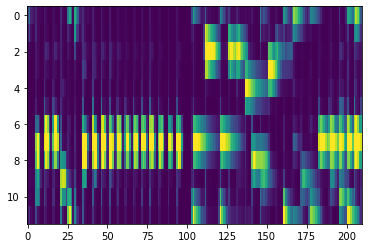

* Recording in progress....
[60/212, 28%] ref: 60, query: 8
[60/212, 28%] ref: 60, query: 48
[80/212, 37%] ref: 80, query: 68
[96/212, 45%] ref: 96, query: 92
[104/212, 49%] ref: 104, query: 124
[116/212, 54%] ref: 116, query: 152
[136/212, 64%] ref: 136, query: 172
[156/212, 73%] ref: 156, query: 192
[180/212, 84%] ref: 180, query: 208
duration: 10.062607765197754
Recording Stopped.


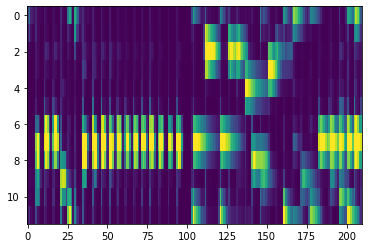

In [14]:
ref_audio_path = "../resources/audio/target/Haydn_Hob.XVI34_1-1.wav"
# ref_audio_path = "../resources/audio/target/Pollini_Maurizio.wav"
SAMPLE_RATE = 22050
CHUNK_SIZE = 4096
HOP_LENGTH = 1024
FRAME_RATE = int(SAMPLE_RATE/HOP_LENGTH) - 1  # 1초당 20 프레임으로 맞춤
N_FFT = 2048
duration = int(librosa.get_duration(filename=ref_audio_path)) + 1

import traceback

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE, hop_length=HOP_LENGTH, n_fft=N_FFT, verbose=False, query_norm=None)
odtw = OnlineTimeWarping(sp, ref_audio_path, window_size=FRAME_RATE*3, verbose=False, hop_length=HOP_LENGTH, max_run_count=3, ref_norm=None)
fig = plt.figure()
ax = fig.gca()
hfig = display(fig, display_id=True)
h = ax.imshow(np.zeros((12, int(SAMPLE_RATE/HOP_LENGTH) * duration)), aspect='auto', vmin=0, vmax=1, interpolation='nearest')

try:
    odtw.run(fig, h, hfig)
    
except Exception as e:
    print(f"error! : {str(e)}, {type(e)}")
    traceback.print_tb(e.__traceback__)
    sp.stop()
    pass

In [52]:
x = odtw.ref_pointer
y = odtw.query_pointer
d = odtw.frame_per_seg
wx = min(odtw.w, x)
wy = min(odtw.w, y)
new_acc = np.zeros((wx, wy))
new_len_acc = np.zeros((wx, wy))

x_seg = odtw.ref_stft[:, x - d : x].T  # [d, 12]
y_seg = odtw.query_stft[:, y - wy : y].T  # [wy, 12]

In [62]:
odtw.ref_total_length, odtw.ref_stft.shape[1]

(620, 616)

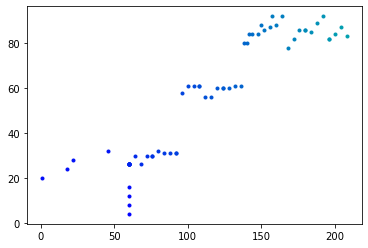

In [5]:
x,y  = zip(*odtw.candi_history)

from matplotlib import cm
cmap = cm.get_cmap('winter', 100)
for n in range(len(x)):
    plt.plot(x[n], y[n], '.', color=cmap(n%100))

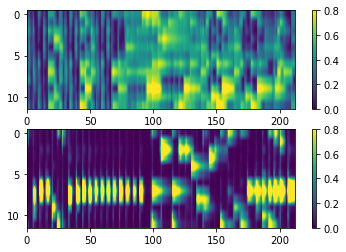

In [15]:
max_step = np.max((odtw.ref_pointer, odtw.query_pointer))
# max_step = np.min((odtw.ref_pointer, odtw.query_pointer))
plt.subplot(211)
plt.imshow(odtw.ref_stft[:, :odtw.ref_pointer], aspect='auto', vmin=0, vmax=0.8)
plt.xlim(0,max_step)
plt.colorbar()
plt.subplot(212)
plt.imshow(odtw.query_stft[:, :odtw.query_pointer], aspect='auto', vmin=0, vmax=0.8)
plt.xlim(0,max_step)
plt.colorbar()

In [24]:
odtw.ref_stft[:, :odtw.ref_pointer].max()
odtw.query_stft[:, :odtw.query_pointer].max()


0.6593953371047974

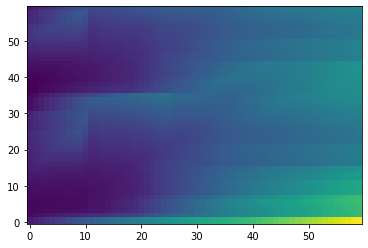

In [54]:
plt.imshow(odtw.acc_dist_matrix.T, aspect='auto', origin='lower')

In [40]:
np.mean(np.abs(odtw.ref_stft[:, :odtw.ref_pointer]))

0.083333336

In [41]:
np.mean(np.abs(odtw.query_stft[:, :odtw.query_pointer]))

0.08333333341068928

In [42]:
np.min(np.abs(odtw.ref_stft)), np.max(np.abs(odtw.ref_stft)), np.min(np.abs(odtw.query_stft[:, :odtw.query_pointer])), np.max(np.abs(odtw.query_stft[:, :odtw.query_pointer]))

(0.00018622246, 0.69931567, 0.0008097818936221302, 0.6673024296760559)

odtw.query_pointer: 204


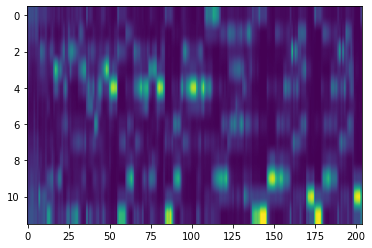

In [56]:
print(f"odtw.query_pointer: {odtw.query_pointer}")
plt.imshow(odtw.query_stft[:, :odtw.query_pointer], aspect='auto')

In [46]:
# check remaining query audio queue size
odtw.sp.chroma_buffer.qsize()

1

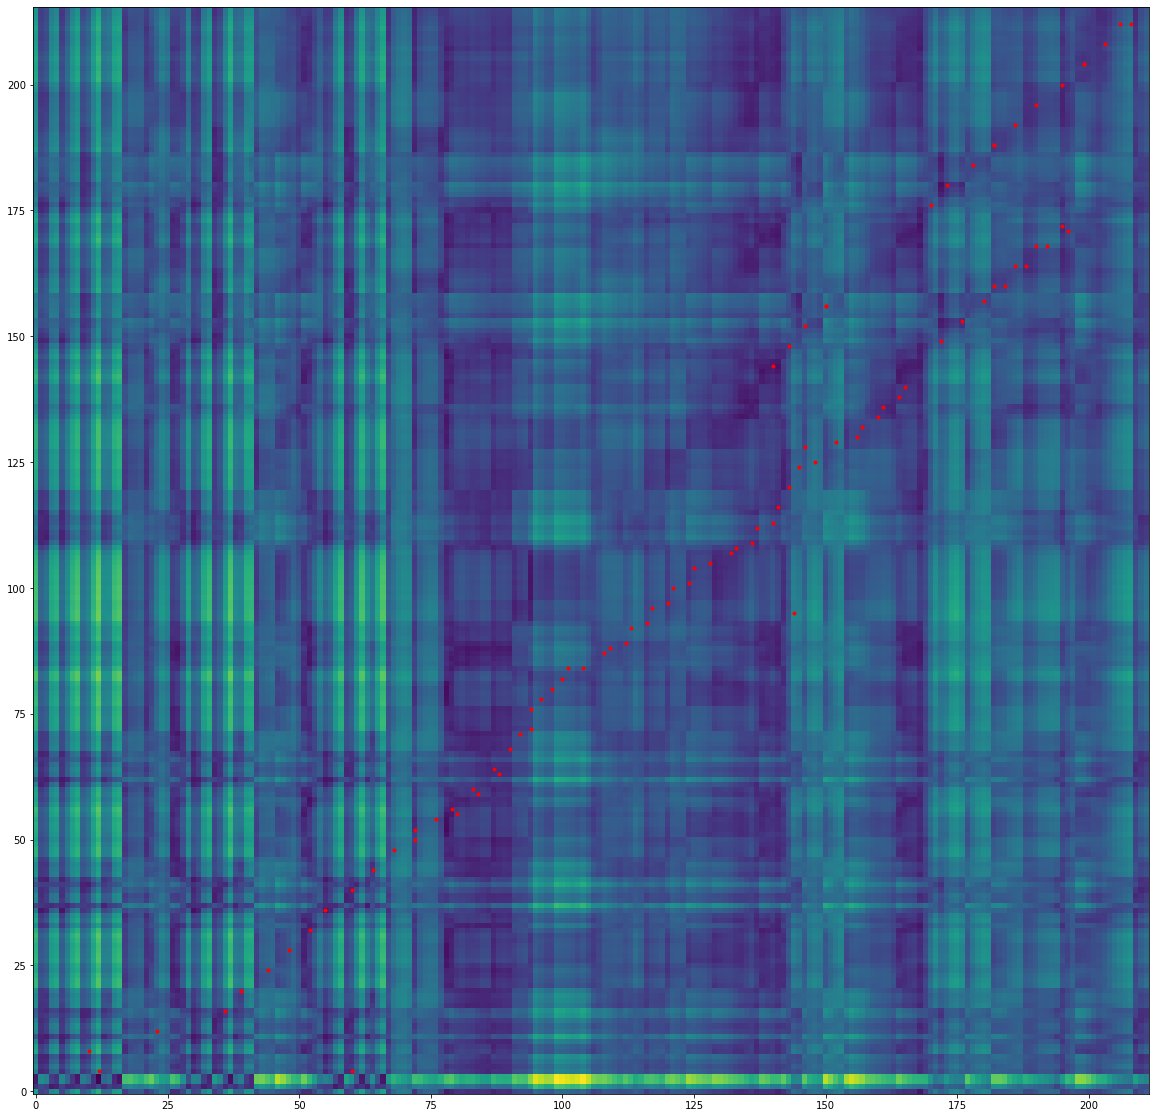

In [19]:
dist = scipy.spatial.distance.cdist(odtw.ref_stft.T, odtw.query_stft[:, :odtw.query_pointer].T)  # [d, wy]
plt.figure(figsize=(20, 20))
plt.imshow(dist.T, aspect='auto', origin='lower', interpolation='nearest')
x,y  = zip(*odtw.candi_history)

from matplotlib import cm
cmap = cm.get_cmap('magma', 100)
for n in range(len(x)):
    plt.plot(x[n], y[n], '.', color='r')

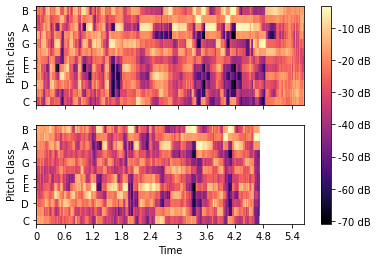

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D1 = librosa.amplitude_to_db(np.abs(odtw.ref_stft[:, :odtw.ref_pointer]))
img = librosa.display.specshow(D1, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].label_outer()

D2 = librosa.amplitude_to_db(np.abs(odtw.query_stft[:, :odtw.query_pointer]))
img = librosa.display.specshow(D2, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")